# Run Camera Calibration to Remove Effect of MTF

The Camera System including lens, sensor, and early pipeline processing does not necessarily have an equal effect on all spatial frequencies - some could be more dampened more than others and some could be boosted. Given that the Spatiotemporal Power Spectrum measure The Modulation Transfer Function describes this effect

## Dependencies

In [20]:
import os, stat
import numpy as np
import msgpack
import cv2
import matplotlib.pyplot as plt
import utils.traceconvert as traceconvert
import random
import glob
import yaml
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (15.0, 10.0)
import utils.bins_to_pngs as bin2png

## Parameters

*** NOTE: REALLY NEED TO CHECK ON THE VALUES FOR HORIZONTAL AND VERTICAL FOV ***

In [24]:
base_dir = '/hmet_data/full_collection_dec2020/'
trial_num = '000'
data_dir = os.path.join(base_dir, 'raw', '2020_12_22', trial_num)
#output_dir = os.path.join(base_dir, 'analysis', 'mtf', trial_num)
#output_dir = os.path.join(base_dir, 'analysis')
#output_dir = './output/matched_frames'

###DEFINITELY NEED TO CHECK ON THESE VALUES
horizontal_fov_deg = 61
#vertical_fov_deg = 61

img_dims=(1544,2064)
save_batchsize = 400

reconvert=False

## Specify Directories for Exmaple

In [19]:
example_trial = 'mtf'
iteration = trial_num
#trial_directory = os.path.join(data_dir, example_subject, iteration)
pngs_dir = os.path.join(base_dir, 'pngs', example_trial, iteration)
save_dir = os.path.join('./output', example_trial, iteration)

try:
    os.makedirs(save_dir)
    os.makedirs(pngs_dir)
except:
    print(f'{save_dir} already made!')

#analysis_folder = os.path.join(output_dir, example_trial, example_subject, iteration)
#common_timeline_file = os.path.join(analysis_folder,'common_timeline.npy')
#pupil_positions_file = os.path.join(trial_directory, 'eye_camera','000','exports','000','pupil_positions.csv')

#three trace conditions: true, none, temporal_match, spatial_match 
#trace_type='fixation_eye_0
#trace_type='none'


## Convert Frames to PNGS

In [25]:
binfilename = os.path.join(data_dir,'ximea','ximea',f'frames_0_{save_batchsize-1}.bin')
first_fnum = 0
if(reconvert):
    bin2png.convert_bin_pngs(binfilename, first_fnum, save_batchsize, pngs_dir)
else:
    print('Skipping conversion step!')

## Read in Imaged Star

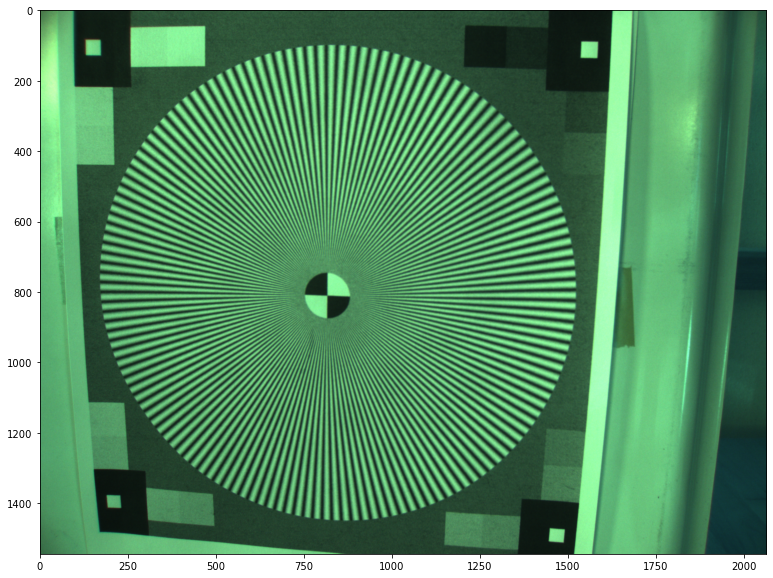

In [31]:
i=30
star_frame = cv2.imread(os.path.join(pngs_dir, f'frame_{i}.png'))
plt.imshow(star_frame)

## Remove Image Warping
Read in Camera Matrix and Distortion Matrix as measured with checkerboard pattern to remove camera distortion

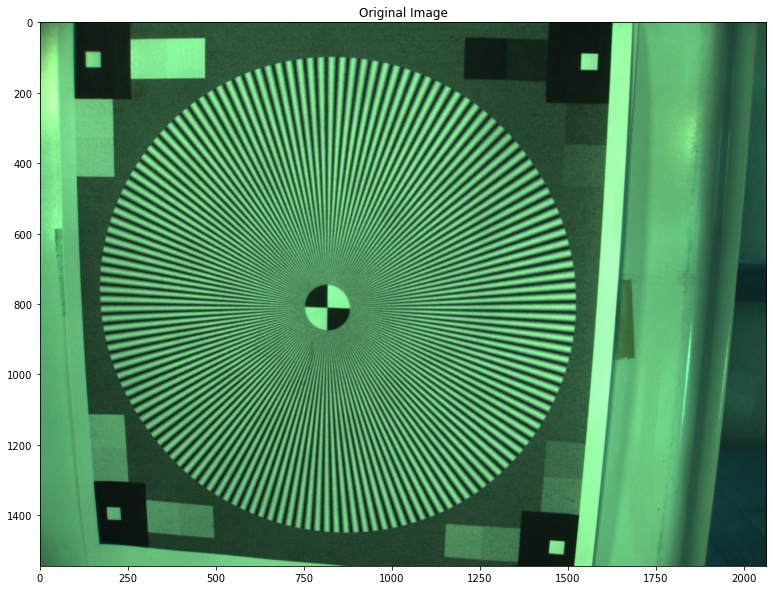

Text(0.5, 1.0, 'Undistorted Image')

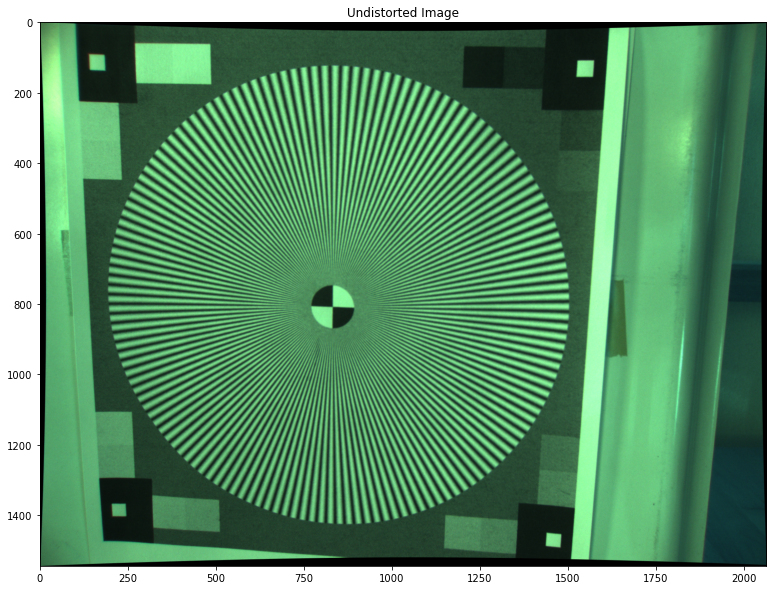

In [46]:
calibration_fname = os.path.join('/','hmet_data','calibration', 'analysis',"calibration_ximea_distortion.yaml")

with open(calibration_fname) as f:
    loadeddict = yaml.load(f, Loader=yaml.BaseLoader)
mtx = np.asarray(loadeddict.get('camera_matrix'), dtype='float32')
dist = np.asarray(loadeddict.get('dist_coeff'), dtype='float32')

h, w = star_frame.shape[:2]
newcameramtx, roi=cv2.getOptimalNewCameraMatrix(mtx,dist,(w,h),1,(w,h))

star_frame_undistorted = cv2.undistort(star_frame, mtx, dist, None, newcameramtx)
plt.imshow(star_frame)
plt.title('Original Image')
plt.show()
plt.imshow(star_frame_undistorted)
plt.title('Undistorted Image')

## Read in Original Star Image

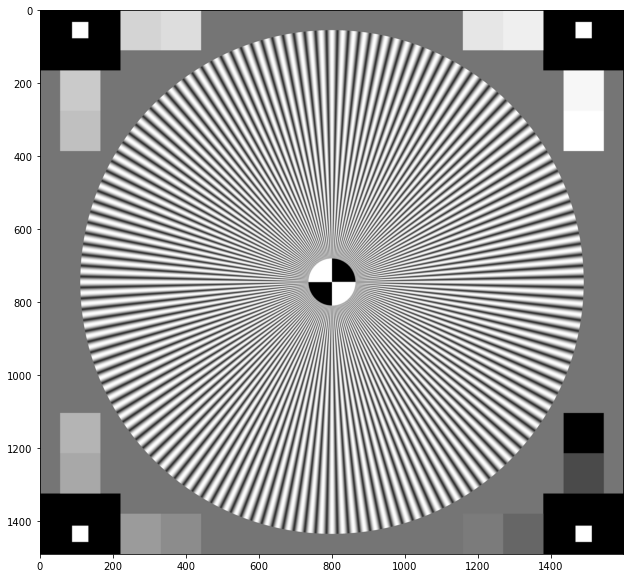

In [32]:
star_img = cv2.imread('./starpattern.png')
plt.imshow(star_img)

## White balance this image
I'm not sure if this is strictly necessary for the alignment and subsequent processing but I really don't want to look at this green/yellow image